In [ ]:
# GRU RNN MODEL

# ETL pipeline -- extract, transform, load

imports

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras, convert_to_tensor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


load df

In [3]:
# Read in df2.csv
df2=pd.read_csv('df2.csv', usecols=['Gene ID', 'Function', 'Location', 'Sequence'])

df2

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Gene ID   68 non-null     object
 1   Function  68 non-null     object
 2   Location  68 non-null     object
 3   Sequence  68 non-null     object
dtypes: object(4)
memory usage: 2.2+ KB


data pre-processing

In [6]:
#add genomic sequences to a list
sequences = []

for index, row in df2.iterrows():
  sequences.append(row["Sequence"])

print("|------------------------------  genomic sequences  ----------------------------|\n\n", sequences)

# one hot encoder method for sequence encoding (at character level)
OHEseq = []
count = -1

for sequence in sequences:
  count += 1
  encoder = OneHotEncoder(dtype=np.uint8) #use np.uint8, more efficient dtype, sufficient for 1's and 0's
  seqArray = np.array(list(sequence)).reshape(-1, 1)
  seq_1hot = encoder.fit_transform(seqArray).toarray()
  OHEseq.append(seq_1hot)

print("\n\n|----------------------  one hot encoded genomic sequences  -------------------|\n\n", OHEseq)

# pad sequences so all same shape (allows for batch processing)
# max len of sequence set to 2000000

padded_sequences = pad_sequences(OHEseq, maxlen=2000000, padding='post', dtype=np.uint8, value=0) # use pad_sequences from tensorflow keras
padded_sequences_flat = []
for sequence in padded_sequences:
  padded_sequences_flat.append(sequence.flatten())

# verify all sequences have same shape
print("\n\n|-----------  demonstration that padding creates uniform shape for genomic sequences  ----------|\n\n")
for array in padded_sequences:
  print("SHAPE: ", array.shape)

# encode functional groups
classes = {'signaling molecule': 0,
               'decoy': 1,
               'scaffold': 2}
classAssigned = np.vectorize(lambda x: classes.get(x, 'Unknown'))(df2["Function"])
print("\n\n|----------------------  functions must be encoded as well...  -------------------|\n\n")
print("Original functional groups\n", df2["Function"])
print("Encoded Functions: \n", classAssigned)



|------------------------------  genomic sequences  ----------------------------|

 ['ACACATGGATATTGGATATCTGCATAGGCAGCTTGCTCCACGCCGGTGCCTACCTGTGCAGATGGGAAGGAAAGGAAAGTGGCAAGGAGGCAGAGAAAGCATCTGTACCCTTACAATTTGGTGAGACAAGAATGTATGAATTCCCACAGGTCAAATTATAATGAAGAAAGGAACCTCTCTTGAGTACAAAGAGCTACCTATGGTGGTCTGGAGCCGGAGGACCACAGCATCAAAGGATATAAGATGCATAGCCAACTGAGGAACCTGAGCAATTAAAGAGATCCACAGTTAAGTCACACTTAACTGGCACTTGTGGAAGCCCCGCAAGGCCTGAAGGAGAGCTGACATAGGCACCCCAGAGAGCCAGAATCTGGATCCCATCTTAATAAGGCCATGAACACCAGTGGAGAAGAGGCAGAAACACCAATGGATAAGGAACATTCACATCTTTCTTCCCATGTGCCTCTAAGTGCCAGTGCAGGCCCCACAGGCCAAGCTACAGGGAGAAAGGAGATGACGCAAAGGAACCTAACTGGACTTTAATCACTAGAAGTGAGAAGAGAAATCTATTGGAACCTCCCAAGATAATGCCAAGGGTCAAAGGGTGCGCAGATACATAAGGTAAGCCCTTCGGTACTTATAAATTTAAAAAAATAAACAGTTGTGGAATGAAGTACCTTAGAAAGGATGAGTTCCCTGTCCCTGGTAGTTTGTAAATAGTTGATGCAGCATGGAGTAGTGGGGATGTGGCCCAAGTTAAGTAACTTAGGTATCCCAGATGGTCATGACATATTCTCCGCTTGAGTCATAACTCATCCCAATGTCCAGTTTTTCAGCCACTCTGCCCAGACTTCAAGGTGGAAAGAACTCAGCACTTACCCAGTCCCACTACCTGTTTCCGCATAATATGCCCT

update df to include encoded sequences and functions


In [7]:
# update df with new encoded features
updatedDF = df2
encodedSequences = padded_sequences_flat

updatedDF['EncodedSequences'] = encodedSequences
updatedDF['EncodedFunctions'] = classAssigned

updatedDF.info()
updatedDF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Gene ID           68 non-null     object
 1   Function          68 non-null     object
 2   Location          68 non-null     object
 3   Sequence          68 non-null     object
 4   EncodedSequences  68 non-null     object
 5   EncodedFunctions  68 non-null     int64 
dtypes: int64(1), object(5)
memory usage: 3.3+ KB


,Gene ID,Function,Location,Sequence,EncodedSequences,EncodedFunctions
0,PCAT1,decoy,8q24.21,ACACATGGATATTGGATATCTGCATAGGCAGCTTGCTCCACGCCGG...,"[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",1
1,MIR4435-2HG,signaling molecule,2q13,ACAAGTATGAAGAGAATGTCGGGAGAGGAAGTGGTGGCTATGAGTC...,"[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",0
2,CASC9,decoy,8q21.13,CCTTGAGCTGTGGTGGGCTCCACCCAGTTGGAGCTTCCTGGCTGCT...,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1
3,LUCAT1,decoy,5q14.3,AATCAACACTCCACTCAGACAATGCCCAGACCTCCAGAAACCATGT...,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",1
4,HAGLR,decoy,2q31.1,AGCTGACGAAGGCGCCGTCGCCGTTGCCCAGAGGGAAGGCGGGCTG...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...,...,...
63,CCAT1,decoy,8q24.21,TTTAAATCATACCAATTGAACCGAGCCTTGTAGAAACACTATCACC...,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...",1
64,Ttc39aos1,scaffold,4 C7,ATTGGCCCTGAGCTCCAGGATGTCAGAAGAGGAAGCAAAAAAGAGC...,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...",2
65,UCA1,decoy,19p13.12,TGACATTCTTCTGGACAATGAGTCCCATCATCTCTCCACCATGCAC...,"[0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, ...",1
66,LINC01133,decoy,1q23.2,CTGATGTAACAGCCTTGGGAAAGAGGTTGCAGTGAAAAGCTGGTCC...,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ...",1


convert data to tensors

In [8]:
# test/train/val split
chosenCols = ["EncodedFunctions", "EncodedSequences"] ##### LOOK INTO THIS possibly encode locations and add into model
train, test = train_test_split(updatedDF[chosenCols], test_size = 0.25, random_state = 42) # use train_test_split from sklearn
train, val = train_test_split(train, test_size=0.2, random_state=42) #split training data into train and validation

# prepare train data for model (convert to tensor)
# must convert to tensor for compatibility with pytorch (allows for faster computation, leveraging GPUs and parallel computing)
trainData = train["EncodedSequences"]

tensorDataTrainList = []
for array in trainData:
  tensorTrainData = torch.tensor(array)
  tensorDataTrainList.append(tensorTrainData)

tensorTrainData = torch.stack(tensorDataTrainList)

trainLabels = train["EncodedFunctions"]

tensorLabelsTrainList = []
for array in trainLabels:
  tensorTrainLabels = torch.tensor(array)
  tensorLabelsTrainList.append(tensorTrainLabels)

tensorTrainLabels = torch.stack(tensorLabelsTrainList)

#prepare validation data
valData = val["EncodedSequences"]

tensorValList = []
for array in valData:
  tensorValData = torch.tensor(array)
  tensorValList.append(tensorValData)

tensorValData = torch.stack(tensorValList)

valLabels = val["EncodedFunctions"]

tensorValList = []
for array in valLabels:
  tensorValLabels = torch.tensor(array)
  tensorValList.append(tensorValLabels)

tensorValLabels = torch.stack(tensorValList)

# prepare test data
testData = test["EncodedSequences"]

tensorDataTestList = []
for array in testData:
  tensorTestData = torch.tensor(array)
  tensorDataTestList.append(tensorTestData)

tensorTestData = torch.stack(tensorDataTestList)

testLabels = test["EncodedFunctions"]

tensorLabelsTestList = []
for array in testLabels:
  tensorTestLabels = torch.tensor(array)
  tensorLabelsTestList.append(tensorTestLabels)

tensorTestLabels = torch.stack(tensorLabelsTestList)



# Create TensorDatasets
# train data
datasetTrainInput = TensorDataset(tensorTrainData, tensorTrainLabels)
print("DATASET: ", datasetTrainInput)

# val data
datasetValInput = TensorDataset(tensorValData, tensorValLabels)
print("DATASET: ", datasetValInput)

# test data
datasetTestInput = TensorDataset(tensorTestData, tensorTestLabels)
print("DATASET: ", datasetTestInput)

# get shape of underlying tensors in TensorDataset
# check all three tensor datasets have same shape
input_shapeTrain = datasetTrainInput.tensors[0].shape[1]
print("INPUT SHAPE TRAIN: ", input_shapeTrain)
input_shapeVal = datasetValInput.tensors[0].shape[1]
print("INPUT SHAPE VAL: ", input_shapeVal)
input_shapeTest = datasetTestInput.tensors[0].shape[1]
print("INPUT SHAPE TEST: ", input_shapeTest)



DATASET:  <torch.utils.data.dataset.TensorDataset object at 0x7cb0aa7ed780>
DATASET:  <torch.utils.data.dataset.TensorDataset object at 0x7cb0aa7efe20>
DATASET:  <torch.utils.data.dataset.TensorDataset object at 0x7cb0aa7ed7e0>
INPUT SHAPE TRAIN:  8000000
INPUT SHAPE VAL:  8000000
INPUT SHAPE TEST:  8000000


GRU RNN Model

In [21]:
# gpu vs cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# pytorch GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True) #this layer is the primary computational layer
        self.fc = nn.Linear(hidden_size, output_size) # connects last timestep output of GRU layer to the output of the model itself

    def forward(self, x):

        # initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)

        out = self.fc(out[:, -1, :]) # picks last timestep of GRU layer to be converted to model output
        return out


input_size = 1  # size of input features at each time step (one nucleotide)
hidden_size = 5  # size of hidden state
# hidden_size parameter designates size of hidden state and controls memory capacity of model
# 5 is likely not an optimal value for this parameter but increasing the hidden_state value causes
# error due to memory capacity being exceeded
# with more resources, i would adjust this parameter to be 32 or 64 although it likely should be even
# higher due to the complexity and length of the input data
output_size = 3  # number of output classes
batch_size = 2
learning_rate = 0.05

# instance of GRU model
model = GRUModel(input_size, hidden_size, output_size).to(device)

Device: cuda


train model

In [ ]:
# dataloaders
dataloaderTrain = DataLoader(datasetTrainInput, batch_size=batch_size, shuffle=True)
dataloaderVal = DataLoader(datasetValInput, batch_size=batch_size, shuffle = True)

# forward pass
for inputs, labels in dataloaderTrain:
    inputs = inputs.to(device).unsqueeze(-1).float() #convert to float
    labels = labels.to(device)

    with torch.no_grad():
        output_tensor = model(inputs)

    # CLEAR FROM MEMORY
    del inputs, labels, output_tensor

# loss function and optimizer
lossFxn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# save train and validation loss values per epoch
trainLossVals = []
valLossVals = []


# training loop
model.train() # set the model to training mode
num_epochs = 5
for epoch in range(num_epochs):
    for trainInputs, trainLabels in dataloaderTrain:
        trainInputs = trainInputs.to(device).unsqueeze(-1).float()
        trainLabels = trainLabels.to(device)

        # forward pass
        trainOutputs = model(trainInputs)

        # compute loss
        trainLoss = lossFxn(trainOutputs, trainLabels)

        # backward pass and optimization
        optimizer.zero_grad()
        trainLoss.backward()
        optimizer.step()

        # validation phase
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
          for valInputs, valLabels in dataloaderVal:
            valInputs = valInputs.to(device).unsqueeze(-1).float()
            valLabels = valLabels.to(device)

            valOutputs = model(valInputs)
            valLoss = lossFxn(valOutputs, valLabels)

        model.train() # back to training mode

    # print training loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {trainLoss.item():.4f}')
    # print validation loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {valLoss.item():.4f}')
    # add train loss values per epoch to trainLossVals list
    trainLossVals.append(trainLoss.item())
    # add validation loss values per epoch to valLossVals list
    valLossVals.append(valLoss.item())
    # save model output
    model_path = './outputs/trained_model.pt'
    torch.save(model.state_dict(), model_path)


print("train loss values: ", trainLossVals)
print("validation loss values: ", valLossVals)

visualization of training and validation loss per epoch

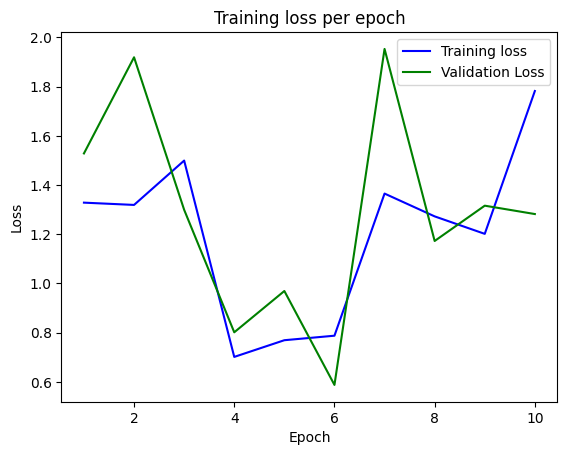

In [ ]:
num_epochs = 5
epochs = range(1, num_epochs + 1)

# plot
plt.plot(epochs, trainLossVals, 'b', label='Training loss')
plt.plot(epochs, valLossVals, 'g', label = "Validation Loss")
plt.title('Training loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model evaluation

In [ ]:
# gpu vs cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# test dataloader
batch_size = 2
dataloaderTest = DataLoader(datasetTestInput, batch_size=batch_size, shuffle=True)

# load saved model
model_path = './outputs/trained_model.pt'
model = GRUModel(input_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load(model_path))

model.eval()  # Set the model to evaluation mode

# loss function, same as function used in training
lossFxn = nn.CrossEntropyLoss()

# evaluate model on testing dataset
lossTest = 0.0
predictions = []
trueLabels = []

with torch.no_grad():
    for inputs, labels in dataloaderTest:
        inputs = inputs.to(device).unsqueeze(-1).float()
        labels = labels.to(device)

        outputs = model(inputs)
        loss = lossFxn(outputs, labels)
        lossTest += loss.item()

        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        trueLabels.extend(labels.cpu().numpy())


# average loss
average_loss = lossTest / len(dataloaderTest)

# confusion matrix
cm = confusion_matrix(trueLabels, predictions)

# classification report
cr = classification_report(trueLabels, predictions)

# print average loss, confusion matrix, and classification report
print(f"Average Loss: {average_loss:.4f}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(cr)

Device: cuda
Average Loss: 1.2711
Confusion Matrix:
[[0 4 0]
 [0 7 0]
 [0 6 0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.41      1.00      0.58         7
           2       0.00      0.00      0.00         6

    accuracy                           0.41        17
   macro avg       0.14      0.33      0.19        17
weighted avg       0.17      0.41      0.24        17



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


class output of individual sequences

In [ ]:
i = 3  # index

input, label = datasetTestInput[i]

input = input.to(device).unsqueeze(-1).float()
label = label.to(device)

# evaluate
model.eval()
with torch.no_grad():
    output = model(input.unsqueeze(0))
    _, predictedClass = torch.max(output, 1)
    predictedClass = predictedClass.item()

# print predicted class and the true label for individual sequence
print(f"Predicted Class: {predictedClass}")
print(f"True Label: {label.item()}")

Predicted Class: 1
True Label: 1
